In [20]:
# ! pip install gym
# ! pip3 install box2d-py
# ! pip install stable-baselines[mpi]==2.10.0 box2d box2d-kengz
# ! pip install 'ribs[all]' gym~=0.17.0 Box2D~=2.3.10 tqdm

In [21]:
import gym
import gym.wrappers

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [22]:
env = gym.make("LunarLander-v2")

In [23]:
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(obs_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, n_actions)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [24]:
def generate_batch(env, batch_size, timelimit=1000):
    activation = nn.Softmax(dim=1)

    batch_actions, batch_states, batch_rewards = [], [], []
    state = None
    for _ in range(batch_size):
        states, actions = [], []
        total_reward = 0
        print(state)
        state = env.reset()

        for _ in range(timelimit):
            # print(state)
            state_tensor = torch.FloatTensor([state])
            act_probs_v = activation(net(state_tensor))

            act_probs = act_probs_v.data.numpy()[0]
            action = np.random.choice(len(act_probs), p=act_probs)

            new_state, reward, done, _ = env.step(action)

            states.append(state)
            actions.append(action)

            total_reward += reward
            state = new_state

            if done:
                batch_actions.append(actions)
                batch_states.append(states)
                batch_rewards.append(total_reward)
                break

    return batch_states, batch_actions, batch_rewards


In [25]:
def filter_batch(states_batch, actions_batch, rewards_batch, percentile=50):
    reward_threshold = np.percentile(rewards_batch, percentile)

    good_states, good_actions = [], []

    for i in range(len(rewards_batch)):
        if rewards_batch[i] > reward_threshold:
            for j in range(len(states_batch[i])):
                good_states.append(states_batch[i][j])
                good_actions.append(actions_batch[i][j])

    return good_states, good_actions


In [26]:
batch_size = 100
session_size = 500
percentile = 80
hidden_size = 200
learning_rate = 0.0025
completion_score = 200
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

In [ ]:
# neural network
net = Net(n_states, hidden_size, n_actions)

# loss function
objective = nn.CrossEntropyLoss()

# optimisation function
optimizer = optim.Adam(params=net.parameters(), lr=learning_rate)

for i in range(session_size):
    # generate new sessions
    batch_states, batch_actions, batch_rewards = generate_batch(
        env, batch_size, timelimit=5000)
    elite_states, elite_actions = filter_batch(
        batch_states, batch_actions, batch_rewards, percentile)

    optimizer.zero_grad()
    tensor_states = torch.FloatTensor(elite_states)
    tensor_actions = torch.LongTensor(elite_actions)

    action_scores_v = net(tensor_states)
    loss_v = objective(action_scores_v, tensor_actions)
    loss_v.backward()
    optimizer.step()

    mean_reward, threshold = np.mean(
        batch_rewards), np.percentile(batch_rewards, percentile)
    print("%d: loss=%.3f, reward_mean=%.1f,reward_threshold=%.1f" %
          (i, loss_v.item(), mean_reward, threshold))

    if np.mean(batch_rewards) > completion_score:
        print("Environment has been successfullly completed!")
        break

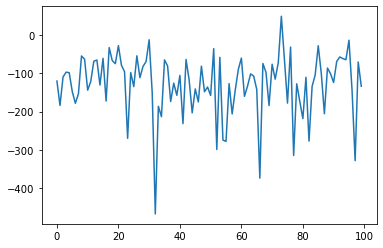

In [28]:
plt.plot(batch_rewards)

In [29]:
batch_rewards

[-120.00080349119844,
 -183.95925560988778,
 -109.00619803512572,
 -96.63163403850852,
 -98.05659895059333,
 -147.82370388384174,
 -178.33657284007438,
 -153.31875607071993,
 -54.1347491552776,
 -62.65295966890491,
 -143.86181820001013,
 -121.21091318114352,
 -68.07624575922668,
 -64.7009802426121,
 -130.47832144666276,
 -60.37533933380677,
 -172.43549791248782,
 -32.10437592838474,
 -66.30669564001482,
 -74.31027274306123,
 -27.15664063332933,
 -78.85577432423571,
 -95.42078705730401,
 -270.1700006101214,
 -97.88170325862751,
 -134.59637800793735,
 -53.779659249286794,
 -111.11269414226471,
 -81.75875016005156,
 -68.76674024498807,
 -11.589794515646759,
 -151.1892575573661,
 -468.5182163817158,
 -186.20349026584708,
 -213.41881104044205,
 -64.49007380763008,
 -80.3076719141424,
 -173.66311638433228,
 -125.53991169675578,
 -157.33615677568622,
 -105.09897987366777,
 -231.67819807336897,
 -63.39925084951108,
 -116.41249008044714,
 -203.4683881042352,
 -140.71621072702715,
 -174.79309080

In [ ]:
env = gym.wrappers.Monitor(env,directory="videofinal", force=True)
generate_batch(env, 1, timelimit=500)
env.close()